# Task 1 (Supervised Learning) - Predicting Donation and Donation Type

In this task you should target 3 classification tasks:
1. **Predicting  Donation (binary classification task)**; 
2. **Predicting Donation TYPE (multiclass classification)**; and
3. **Train specialized models for SES (socioeconomic classification)**.

**You should:**

* Choose **one classifier in each category**: Tree models, Rule models, Linear models, Distance-based models, and Probabilistic models.
* Use cross-validation to evaluate the results. 
* Present and discuss the results for different evaluation measures, present confusion matrices. Remember that not only overall results are important. Check what happens when learning to predict each class.
* Describe the parameters used for each classifier and how their choice impacted or not the results.
* Choose the best classifier and fundament you choice.
* **Discuss critically your choices and the results!**

## Supervised Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from IPython.display import Image, display;  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import neighbors
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from multi_imbalance.utils.plot import plot_cardinality_and_2d_data

### Preprocessing Data for Classification

In [2]:
df_clean = pd.read_csv('donors_dataset_clean.csv') 
df_clean.head()

,TARGET_B,TARGET_D,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,SES,CLUSTER_CODE,INCOME_GROUP,MOR_HIT_RATE,MEDIAN_HOME_VALUE,...,LIFETIME_GIFT_RANGE_BIN,LAST_GIFT_AMT_BIN,CARD_PROM_12_BIN,NUMBER_PROM_12_BIN,MONTHS_SINCE_LAST_GIFT_BIN,MONTHS_SINCE_FIRST_GIFT_BIN,FILE_CARD_GIFT_BIN,INCOME_GROUP_BIN,RECENCY_STATUS_96NK_e,DONATION_TYPE
0,1.0,10.0,137.0,79.000000,0.0,2.0,45.0,7.0,0.0,334.0,...,"(15.0, 30.0]","(15.0, 30.0]","(3.0, 9.0]","(20.0, 30.0]","(-0.1, 8.0]","(120.0, 260.0]","(10.0, 20.0]","(6.4, 8.337]",4.0,D
1,0.0,0.0,113.0,75.000000,0.0,1.0,11.0,5.0,0.0,2388.0,...,"(15.0, 30.0]","(15.0, 30.0]","(9.0, 14.0]","(30.0, 64.0]","(-0.1, 8.0]","(80.0, 120.0]","(10.0, 20.0]","(4.4, 5.4]",4.0,NaN
2,0.0,0.0,92.0,62.695162,0.0,2.0,4.0,6.0,0.0,1688.0,...,"(-0.1, 15.0]","(-0.1, 15.0]","(9.0, 14.0]","(30.0, 64.0]","(-0.1, 8.0]","(80.0, 120.0]","(10.0, 20.0]","(5.4, 6.4]",0.0,NaN
3,0.0,0.0,101.0,74.000000,0.0,2.0,49.0,2.0,8.0,514.0,...,"(15.0, 30.0]","(15.0, 30.0]","(3.0, 9.0]","(10.0, 20.0]","(16.0, 24.0]","(80.0, 120.0]","(-0.1, 10.0]","(1.4, 2.4]",0.0,NaN
4,0.0,0.0,101.0,63.000000,0.0,3.0,8.0,3.0,0.0,452.0,...,"(-0.1, 15.0]","(-0.1, 15.0]","(3.0, 9.0]","(10.0, 20.0]","(16.0, 24.0]","(80.0, 120.0]","(-0.1, 10.0]","(2.4, 3.4]",0.0,NaN


#### Data and classes 

Similar to Task 1.1, we need to predict if the type of donation. Thus we will use a subset of the dataset with DONORS ONLY. We will not consider the columns: TARGET_B, TARGET_D and binned data.

In [4]:
categorical_columns = ['DONOR_AGE_BIN', 'MONTHS_SINCE_ORIGIN_BIN','INCOME_GROUP_BIN', 'MOR_HIT_RATE_BIN', 'MEDIAN_HOME_VALUE_BIN', 
                       'MEDIAN_HOUSEHOLD_INCOME_BIN', 'PCT_OWNER_OCCUPIED_BIN', 'PER_CAPITA_INCOME_BIN', 'PCT_ATTRIBUTE1_BIN',
                      'PCT_ATTRIBUTE2_BIN', 'PCT_ATTRIBUTE3_BIN', 'PCT_ATTRIBUTE4_BIN', 'RECENT_RESPONSE_PROP_BIN',
                      'RECENT_AVG_GIFT_AMT_BIN', 'RECENT_CARD_RESPONSE_PROP_BIN', 'RECENT_AVG_CARD_GIFT_AMT_BIN',
                      'RECENT_RESPONSE_COUNT_BIN', 'RECENT_CARD_RESPONSE_COUNT_BIN', 'MONTHS_SINCE_LAST_PROM_RESP_BIN',
                      'LIFETIME_CARD_PROM_BIN', 'LIFETIME_PROM_BIN', 'LIFETIME_GIFT_AMOUNT_BIN','LIFETIME_GIFT_COUNT_BIN',
                      'LIFETIME_AVG_GIFT_AMT_BIN', 'LIFETIME_GIFT_RANGE_BIN', 'LAST_GIFT_AMT_BIN', 'CARD_PROM_12_BIN',
                      'NUMBER_PROM_12_BIN', 'MONTHS_SINCE_LAST_GIFT_BIN', 'MONTHS_SINCE_FIRST_GIFT_BIN', 'FILE_CARD_GIFT_BIN']

In [5]:
# In this subset, we will only consider donors (TARGET_B == 1 or DONATION_TYPE == NaN)
df_clean.drop(df_clean[df_clean['DONATION_TYPE'].isnull()].index, inplace=True)
df_clean.drop(columns= ['TARGET_B','TARGET_D'], inplace=True)
df_clean.drop(columns= categorical_columns, inplace=True)

In [3]:
# Class Distribution
print('Class A: ',len(df_clean.loc[df_clean['DONATION_TYPE']=='A']))
print('Class B: ',len(df_clean.loc[df_clean['DONATION_TYPE']=='B']))
print('Class C: ',len(df_clean.loc[df_clean['DONATION_TYPE']=='C']))
print('Class D: ',len(df_clean.loc[df_clean['DONATION_TYPE']=='D']))
print('Class E: ',len(df_clean.loc[df_clean['DONATION_TYPE']=='E']))

Class A:  96
Class B:  1269
Class C:  876
Class D:  1135
Class E:  1021


In [6]:
# Encode the categorical data - donation type 
ord_enc = OrdinalEncoder()
df_clean["DONATION_TYPE"] = ord_enc.fit_transform(df_clean[["DONATION_TYPE"]])

In [7]:
# Data preparation: from dataframe to arrays
nc = df_clean.shape[1]
matrix = df_clean.values 
X = matrix [:, 0:nc-1]
y = matrix [:, nc-1]          
features = df_clean.columns.values[0:nc-1] 
target = df_clean.columns.values[nc-1]

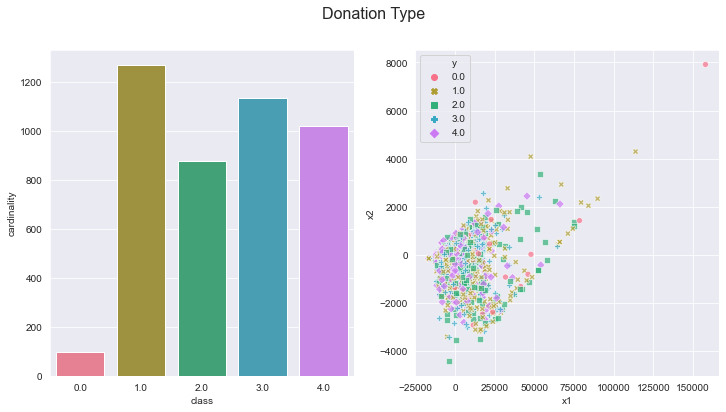

In [8]:
# Visualization of the classes
# Plot 1 (left): Barplot with the cardinality of classes from y
# Plot2 (right): Scatter plot of X transformed to two dimensions using PCA
plot_cardinality_and_2d_data(X, y, 'Donation Type')

The data is imbalanced. The first class has less datapoints when compared to all others. Like in Task 1.1, we will perform a data split with stratification and account for this difference. We will also perform cross validation with sklearn.model_selection.cross_val_score() with the splitting strategy - cv = int. By defaults, this method stratifies the data by appliyng a StratifiedKFold approach.

#### Data split 

To evaluate the models, we need to test them on a testing set independent from the training set. This separate analysis allows for overfitting control.

In [9]:
# Split the data 
# Training set: 0.75
# Testing set: 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Learning Classifiers

####  CN2 Algorithm

The RIPPER algorithm is best suited for binary data. Therefore, we employed the rule induction algorithm CN2, available in Orange. CN2 was designed for the efficient induction of simple, comprehensible production rules in domains where problems of poor description language and/or noise may be present. In other words, it should work even when the training data is imperfect. 

##### Orange Workflow

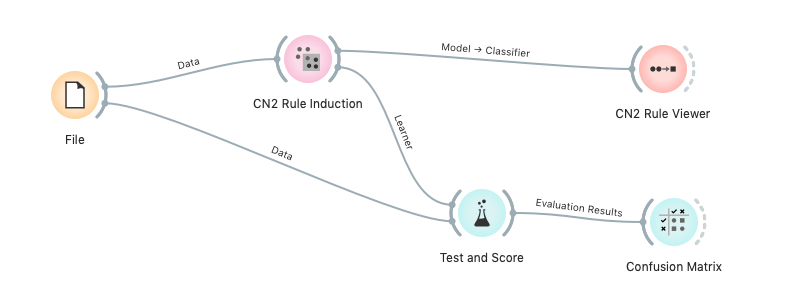

In [10]:
display(Image(filename='cn2_workflow.png'))

##### Parameters

The parameters

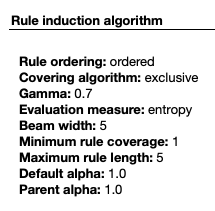

In [11]:
display(Image(filename='cn2_params.png'))

For a list of the first 99 rules induces, refer to the cn2_report.html file.

### Model Evaluation

#### CN2 Algorithm (Orange)

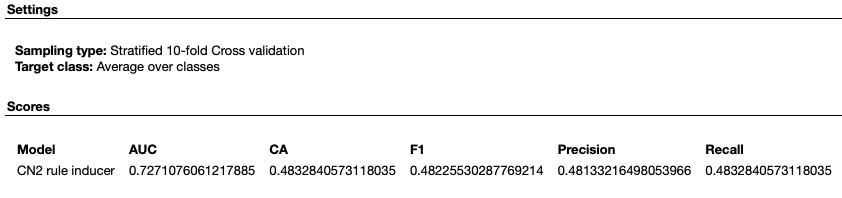

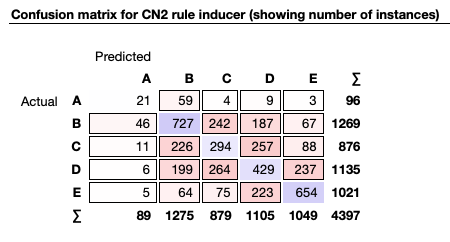

In [12]:
display(Image(filename='cn2_scores.png'))
display(Image(filename='cn2_cm.png'))

####  Decision Trees, Naive Bayes Classifier, Linear Regression and K-Nearest Neighbours

In [13]:
#Code to supress warnings. For the Logistic Regression, the model does not converge and an warning is issued.
from warnings import filterwarnings
filterwarnings('ignore')

In [14]:
## Classifiers - Set the different parameters for each model

# Decision Trees
dt = tree.DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=10)
# Naive Bayes Classifier
gnb = GaussianNB()
# Linear Regression
lr = LogisticRegression(max_iter=3000)
# K-Nearest Neighbours
knn = neighbors.KNeighborsClassifier(n_neighbors=10)

##### Cross-Validation 

In [15]:
models = [dt, gnb, lr, knn]
names = ['Decision Tree', 'Naive Bayes Classifier','Linear Regression','K-Nearest Neighbours']

for model, name in zip(models, names):
    f1_macro = cross_val_score(model, X, y, cv=10, scoring='f1_macro')
    f1_weighted = cross_val_score(model, X, y, cv=10, scoring = 'f1_weighted')
    recall_macro = cross_val_score(model, X, y, cv=10, scoring='recall_macro')
    recall_weighted  = cross_val_score(model, X, y, cv=10, scoring = 'recall_weighted')
    accuracy_cv = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    
    print('Cross-Validation {name} - F1 Micro: %0.2f (+/- %0.2f)'.format(name=name) % (f1_macro.mean(), f1_macro.std() * 2))
    print('Cross-Validation {name} - F1 Weighted: %0.2f (+/- %0.2f)'.format(name=name) % (f1_weighted.mean(), f1_weighted.std() * 2))
    print('Cross-Validation {name} - Recall Micro: %0.2f (+/- %0.2f)'.format(name=name) % (recall_macro.mean(), recall_macro.std() * 2))
    print('Cross-Validation {name} - Recall Weighted: %0.2f (+/- %0.2f)'.format(name=name) % (recall_weighted.mean(), recall_weighted.std() * 2))
    print('Cross-Validation {name} - Accuracy: %0.2f (+/- %0.2f)'.format(name=name) % (accuracy_cv.mean(), accuracy_cv.std() * 2),'\n')

Cross-Validation Decision Tree - F1 Micro: 0.63 (+/- 0.08)
Cross-Validation Decision Tree - F1 Weighted: 0.65 (+/- 0.03)
Cross-Validation Decision Tree - Recall Micro: 0.64 (+/- 0.09)
Cross-Validation Decision Tree - Recall Weighted: 0.65 (+/- 0.03)
Cross-Validation Decision Tree - Accuracy: 0.65 (+/- 0.03) 

Cross-Validation Naive Bayes Classifier - F1 Micro: 0.51 (+/- 0.13)
Cross-Validation Naive Bayes Classifier - F1 Weighted: 0.53 (+/- 0.08)
Cross-Validation Naive Bayes Classifier - Recall Micro: 0.54 (+/- 0.09)
Cross-Validation Naive Bayes Classifier - Recall Weighted: 0.53 (+/- 0.08)
Cross-Validation Naive Bayes Classifier - Accuracy: 0.53 (+/- 0.08) 

Cross-Validation Linear Regression - F1 Micro: 0.46 (+/- 0.12)
Cross-Validation Linear Regression - F1 Weighted: 0.53 (+/- 0.05)
Cross-Validation Linear Regression - Recall Micro: 0.48 (+/- 0.10)
Cross-Validation Linear Regression - Recall Weighted: 0.57 (+/- 0.04)
Cross-Validation Linear Regression - Accuracy: 0.57 (+/- 0.04) 

Cr

##### Training vs. Testing 

Accuracy Score Training Set Decision Tree - F1 Macro:  0.6384468019927115
Accuracy Score Training Set Decision Tree - F1 Weighted:  0.6573149190236063
Accuracy Score Training Set Decision Tree - Recall Macro:  0.6431998212073469
Accuracy Score Training Set Decision Tree - Recall Weighted:  0.6551410373066424
Accuracy Score Training Set Decision Tree - Accuracy:  0.6551410373066424 

Accuracy Score Training Set Naive Bayes Classifier - F1 Macro:  0.5272684742675617
Accuracy Score Training Set Naive Bayes Classifier - F1 Weighted:  0.5426411046083813
Accuracy Score Training Set Naive Bayes Classifier - Recall Macro:  0.561734511381778
Accuracy Score Training Set Naive Bayes Classifier - Recall Weighted:  0.5556566575674856
Accuracy Score Training Set Naive Bayes Classifier - Accuracy:  0.5556566575674856 

Accuracy Score Training Set Linear Regression - F1 Macro:  0.4740125350847461
Accuracy Score Training Set Linear Regression - F1 Weighted:  0.5394342788000113
Accuracy Score Training S

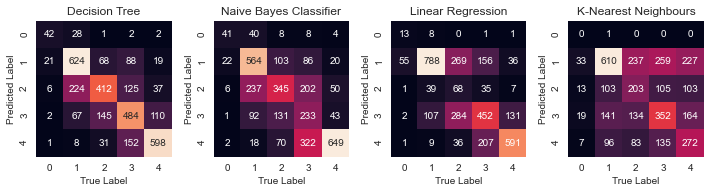

In [16]:
models = [dt, gnb, lr, knn]
names = ['Decision Tree', 'Naive Bayes Classifier','Linear Regression','K-Nearest Neighbours']

f, axes = plt.subplots(1, 4, figsize=(10, 10))
f.tight_layout()

for model, name, i in zip(models, names, range(len(names))):

    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
        
    f1_macro = f1_score(y_train, y_pred, average='macro')
    f1_wighted = f1_score(y_train, y_pred, average='weighted')
    recall_macro = recall_score(y_train, y_pred, average='macro')
    recall_wighted = recall_score(y_train, y_pred, average='weighted')
    accuracy = accuracy_score(y_train, y_pred)
        
    print('Accuracy Score Training Set {name} - F1 Macro: '.format(name=name), f1_macro)
    print('Accuracy Score Training Set {name} - F1 Weighted: '.format(name=name), f1_wighted)
    print('Accuracy Score Training Set {name} - Recall Macro: '.format(name=name), recall_macro)
    print('Accuracy Score Training Set {name} - Recall Weighted: '.format(name=name), recall_wighted)
    print('Accuracy Score Training Set {name} - Accuracy: '.format(name=name), accuracy, '\n')
        
    cm_train = confusion_matrix(y_train, y_pred)

    sns.heatmap(cm_train.T, square=True, annot=True, fmt='d', cbar=False, ax=axes[i])
    axes[i].set_xlabel('True Label')
    axes[i].set_ylabel('Predicted Label');
    axes[i].set_title(name)

Accuracy Score Testing Set Decision Tree - F1 Macro:  0.6350939384501766
Accuracy Score Testing Set Decision Tree - F1 Weighted:  0.6577523160119403
Accuracy Score Testing Set Decision Tree - Recall Macro:  0.648877917284009
Accuracy Score Testing Set Decision Tree - Recall Weighted:  0.6554545454545454
Accuracy Score Testing Set Decision Tree - Accuracy:  0.6554545454545454 

Accuracy Score Testing Set Naive Bayes Classifier - F1 Macro:  0.49223075750621126
Accuracy Score Testing Set Naive Bayes Classifier - F1 Weighted:  0.506535061453671
Accuracy Score Testing Set Naive Bayes Classifier - Recall Macro:  0.5359107276706219
Accuracy Score Testing Set Naive Bayes Classifier - Recall Weighted:  0.52
Accuracy Score Testing Set Naive Bayes Classifier - Accuracy:  0.52 

Accuracy Score Testing Set Linear Regression - F1 Macro:  0.4634617705616284
Accuracy Score Testing Set Linear Regression - F1 Weighted:  0.5368810824675613
Accuracy Score Testing Set Linear Regression - Recall Macro:  0.4

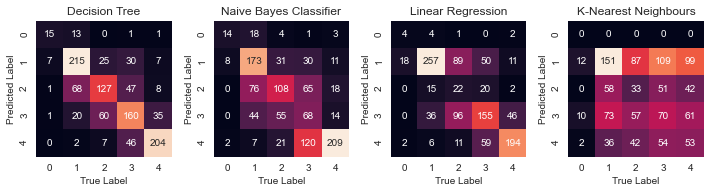

In [17]:
# Testing Data

f, axes = plt.subplots(1, 4, figsize=(10, 10))
f.tight_layout()

for model, name, i in zip(models, names, range(len(names))):
    
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
        
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_wighted = f1_score(y_test, y_pred, average='weighted')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    recall_wighted = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
        
    print('Accuracy Score Testing Set {name} - F1 Macro: '.format(name=name), f1_macro)
    print('Accuracy Score Testing Set {name} - F1 Weighted: '.format(name=name), f1_wighted)
    print('Accuracy Score Testing Set {name} - Recall Macro: '.format(name=name), recall_macro)
    print('Accuracy Score Testing Set {name} - Recall Weighted: '.format(name=name), recall_wighted)
    print('Accuracy Score Testing Set {name} - Accuracy: '.format(name=name), accuracy, '\n')
        
    cm_test = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm_test.T, square=True, annot=True, fmt='d', cbar=False, ax=axes[i])
    axes[i].set_xlabel('True Label')
    axes[i].set_ylabel('Predicted Label');
    axes[i].set_title(name)

## Results and Discussion 

**Setting the Parameters**

The process to choose the best parameters for each classifier was similar to Task 1.1. For the DT classifier, using 'entropy' to determine the quality of a split also displayed better results than the gini impurity function (criterion='gini'). However, a lower value for the max_leaf_nodes was suficient to improve performance before reaching a plateau. No other parameter seemed to have an impact on the scores. As for the Logistic Regression, increasing the maximum number of iterations did not lead to model convergence. Yet, the minimum value for max_iter that would still display the best performance possible was almost ten times higher than the value for binary classification. The adjustment of the solvers did not show any differences in performance. The algorithm choice for the KNN classifier also did not affect the model scores. Nevertheless, adjusting the number of neighbours to 10 returned the best results. Finally, default parameters were maintained for both NBC and CN2 algorithm.

**Metrics: F1 Macro, F1 Weighted, Recall Macro, Recall Weighted and Accuracy**

In contrast to the results described in Task 1.1, the five metrics calculated for this multi-class classification task returned similar results between themselves. This could be due to the fact that only one class is imbalanced (Class 0). Indeed, the confusion matrixes for all the tested classifiers show lower classification for the first class (Class 0). While, with better or worse performances, all other classes seem to be more populated.

**Evaluation Methods: 10-Fold Cross Validation and Test Split**

To evaluate the models we performed cross validation and a test split. As in Task 1.1, the results were similar between the two methods. However, there is a slight discrepancy between the cross validation (CV) scores and the scores for the training set of the KNN classifier. In parallel, the scores for the testing set of the same model are similar to the ones registed for the CV. This suggests that the model is overfitting the training data, although the performance is still poor. In addition, these results indicate a lower sensitivity to overfitting in this CV method.

**Comparison Between Classifiers**

The results were generally worse when compared with the binary classification task. Nevertheless, it is clear that the KNN model presents the worst performance of the five classifiers. The results suggest the model is not learning at all. In contrast, the DT classifier has the highest scores in comparison to all the other models tested. Unlike a univariate decision tree, a multivariate decision tree is not restricted to splits of the instance space that are orthogonal to the features' axes. As the number of variables increases, multivariate decision trees make fewer errors on previously unobserved instances than univariate decision trees (Brodley, C.E., Utgoff, P.E. Multivariate Decision Trees. Machine Learning 19, 45–77 (1995)). On a different note, similarly to Task 1.1, all the classifiers, with the exception of NBC, seem to be highly sensitive to variations in cardinality between classes. The confusion matrixes show higher accuracy levels when classifying class 1. On the contrary, the classificaion level for class 0 is incredibly low. The other 3 classes are more balanced, thus no clear pattern of classification is discernible. The results for the NBC are consistend with the ones from the binary classification task. Although the performance is poor, it seems to be more rebust to multi-class imbalanced data. Overall, no classifier was able to perform well for this task. Regardless, based on these results, the DT classifier is clearly the best suited model to perform multi-class classification in our data and the model we will choose for Task 1.4. 